# Identify AR Events

In [1]:
%matplotlib ipympl

In [2]:
import ARUtils
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

Load data from 1980 - 1989

In [3]:
ds = xr.open_dataset('b.e21.BHISTsmbb.f09_g17.LE2-1111.006.cam.h2.IVT.1980010100-1989123100.nc')

Select a single grid cell that covers Bodega Bay, CA (38.3332° N, 123.0481° W)

In [4]:
lat = 38.
lon = -123.125 + 360 
AR_THRESHOLD = 250.
ds_cell = ds.sel(lat=lat, lon=lon, method='nearest').IVT

Plot the IVT data for this cell 

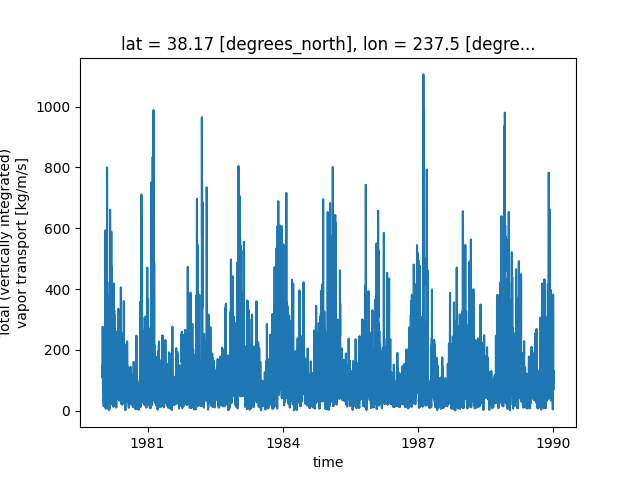

In [5]:
fig, ax = plt.subplots()
ds_cell.plot();

Plot all the IVT values above the 250 kg/m/s threshold.

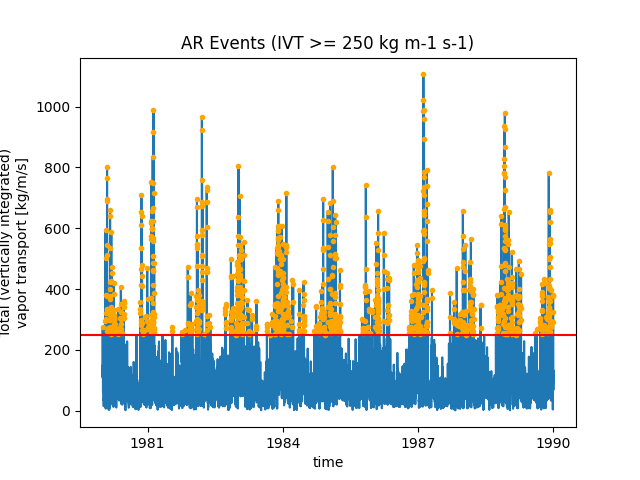

In [6]:
fig, ax = plt.subplots()
ds_cell.plot()
ds_cell.where((ds_cell >= AR_THRESHOLD)).plot(linestyle='', marker='.', color='orange')
ax.axhline(y=AR_THRESHOLD, color='red')
plt.title('AR Events (IVT >= 250 kg m-1 s-1)')
plt.show()

Categorize AR Events

In [8]:
# compute AR indices 
dat = ARUtils.create_ar_index_for_grid_cell(ds_cell.to_dataset())

# compute AR categories
dat = ARUtils.compute_ar_categories(dat)

Plot all AR Categories

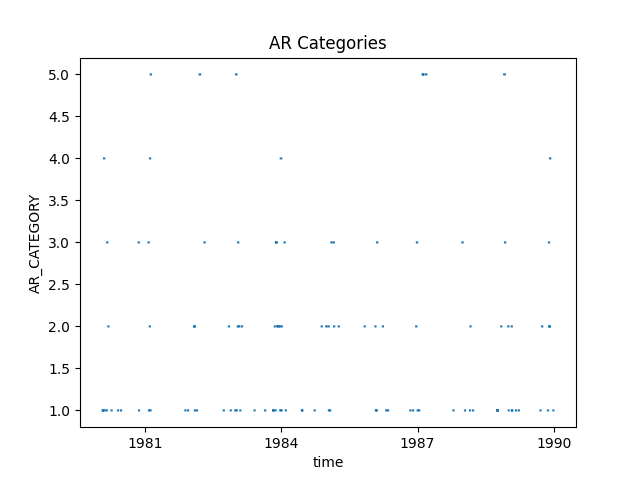

In [9]:
# plot AR Categories
fig, ax = plt.subplots()
dat.where(dat.AR_CATEGORY > 0).AR_CATEGORY.plot()
plt.title('AR Categories');

Plot all CAT-5 AR Events

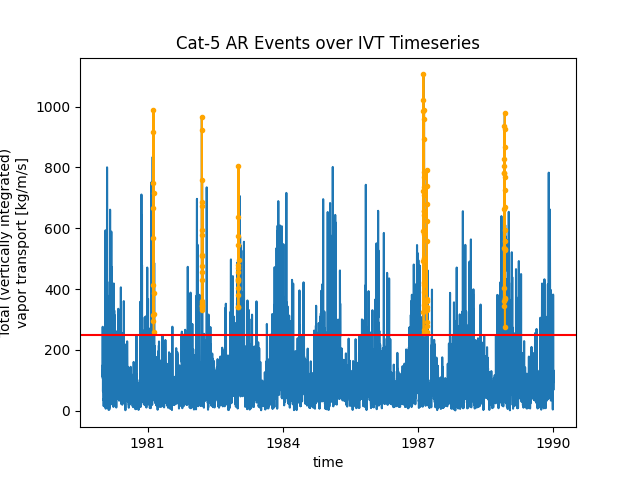

In [10]:
fig, ax = plt.subplots()
dat.IVT.plot()

dat5 = dat.where(dat.AR_CATEGORY == 5, drop=True)
for idx, dd in dat5.groupby(dat5.AR_INDEX):
        vals = dd.IVT.values
        if len(vals) > 1:
            dd.IVT.plot(linestyle='-', marker='.', color='orange')

ax.axhline(y=AR_THRESHOLD, color='red')
plt.title('Cat-5 AR Events over IVT Timeseries')
plt.show()